# Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten
from IPython.display import HTML, display
import os
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

In [4]:
data_rel_path = "..\\..\\..\\datasets_collection\\Traffic_Sign_Classifier"
training_file = os.path.join(data_rel_path, 'train.p')
validation_file= os.path.join(data_rel_path, 'valid.p')
testing_file = os.path.join(data_rel_path, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

n_train = np.shape(X_train)[0]
n_test = np.shape(X_test)[0]
n_valid = np.shape(X_valid)[0]
image_shape = np.shape(X_train[0])
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Read Ground Truth Labels

__Key idea:__

Read Traffic signs labels from csv.

In [6]:
import csv

with open('signnames.csv') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    signname = []
    for row_id,row in enumerate(csv_reader):
        if row_id == 0:
            pass # ignore header
        else:
            signname.append(row[1])

## Read Ground Truth Images

__Key idea:__

Read Traffic signs Ground Truth Images associated with its label.

In [8]:
import os
signs_dir = 'signs/'
signs_images=os.listdir(signs_dir)
ground_truth_signs = []
ground_truth_labels = []
for img_name in signs_images:
    img = cv2.imread(signs_dir+img_name)
    ground_truth_signs.append(img[:,:,::-1])
    ground_truth_labels.append(int(img_name.split('.')[0]))
ground_truth_labels = np.array(ground_truth_labels)

# Visualization of Dataset

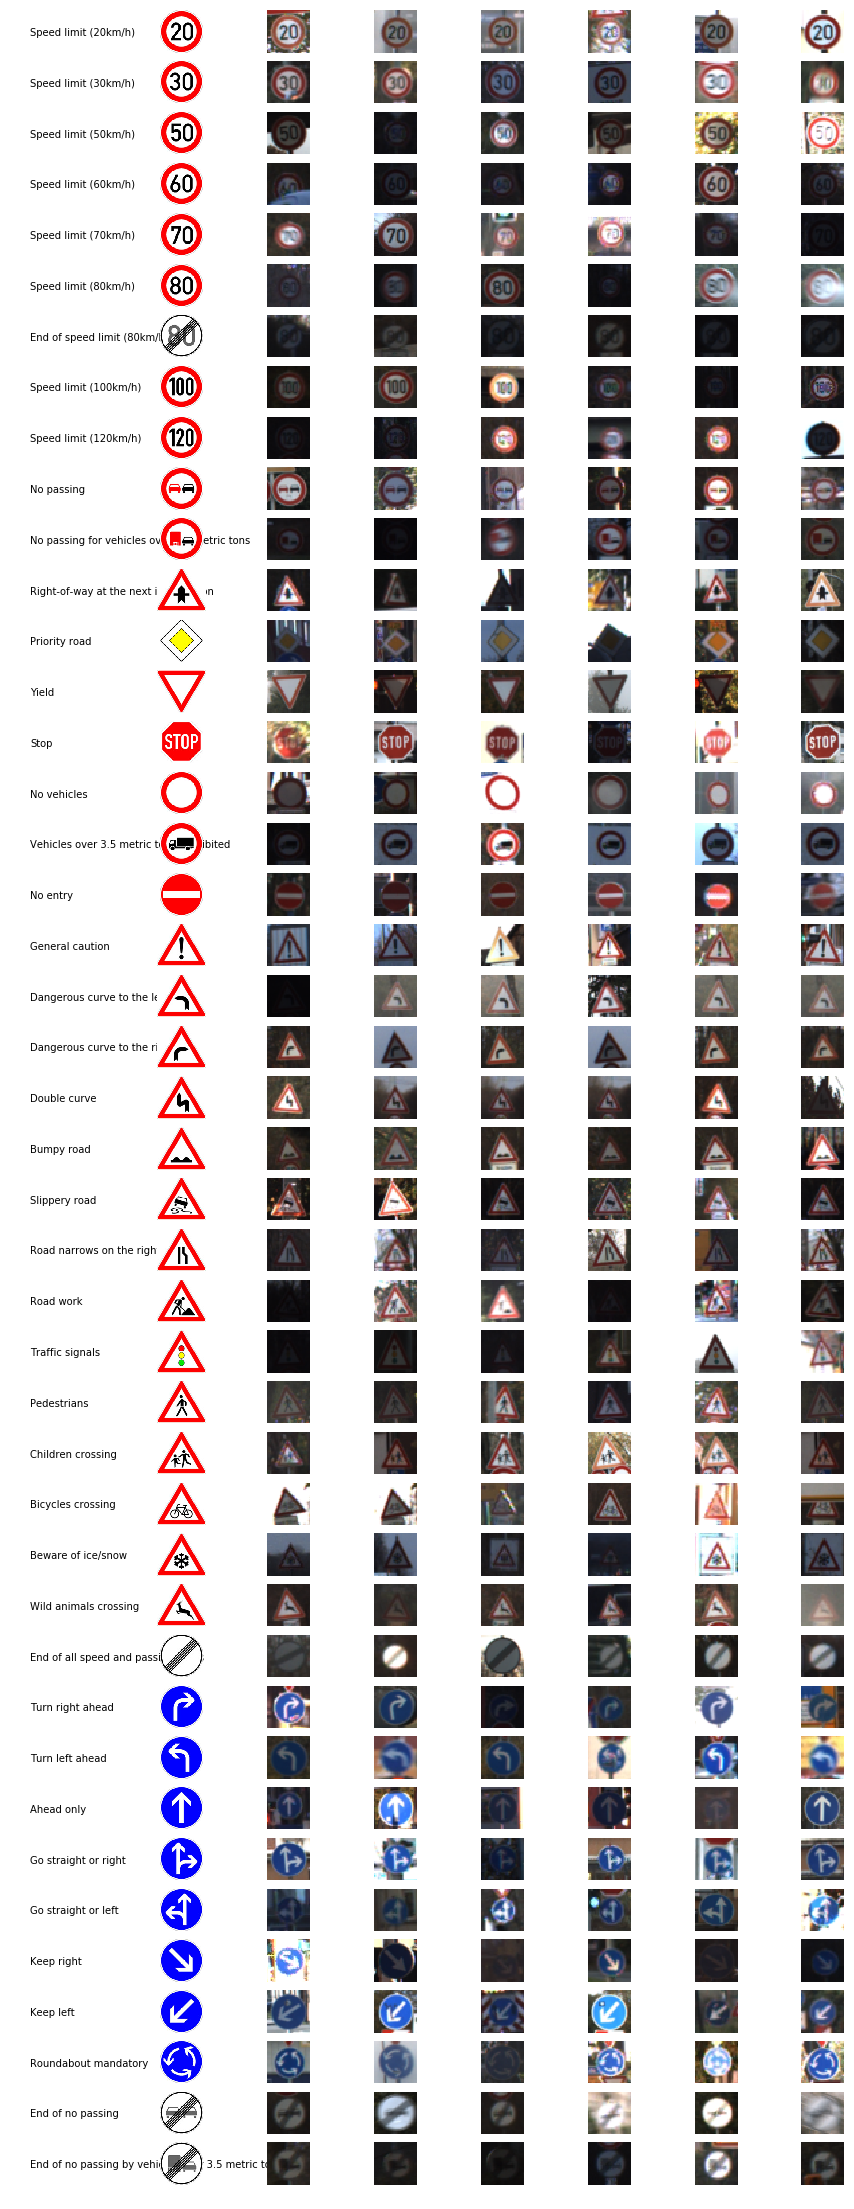

In [9]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(n_classes, 8)

data_index = [np.where(np.array(y_train)==classid)[0] for classid in range(n_classes)]
# plot samples for each traffic signs 
data_set_fig = plt.figure(num=1,figsize=(15, 40))
# st = data_set_fig.suptitle("Training  DataSet Samples", fontsize="x-large")
ax = []
for class_id in range(n_classes):
    # plot ground truth label
    ax.append(data_set_fig.add_subplot(gs[class_id, 0]))
    ax[-1].text(0, 0.6, signname[class_id], ha='left', va='top', wrap=True)
    ax[-1].set_axis_off()
    
    # plot ground truth image
    ax.append(data_set_fig.add_subplot(gs[class_id, 1]))
    gt_image_id = np.where(np.array(ground_truth_labels)==class_id)[0][0]
    ax[-1].imshow(ground_truth_signs[gt_image_id])
    ax[-1].set_axis_off()
    # plot random samples for each class
    index = np.random.choice(data_index[class_id], 6,replace=False)
    for sample in range(6):
        image = X_train[index[sample]].squeeze()
        ax.append(data_set_fig.add_subplot(gs[class_id, sample+2]))
        ax[-1].imshow(image)
        ax[-1].set_axis_off()


## Histogram of Training Dataset

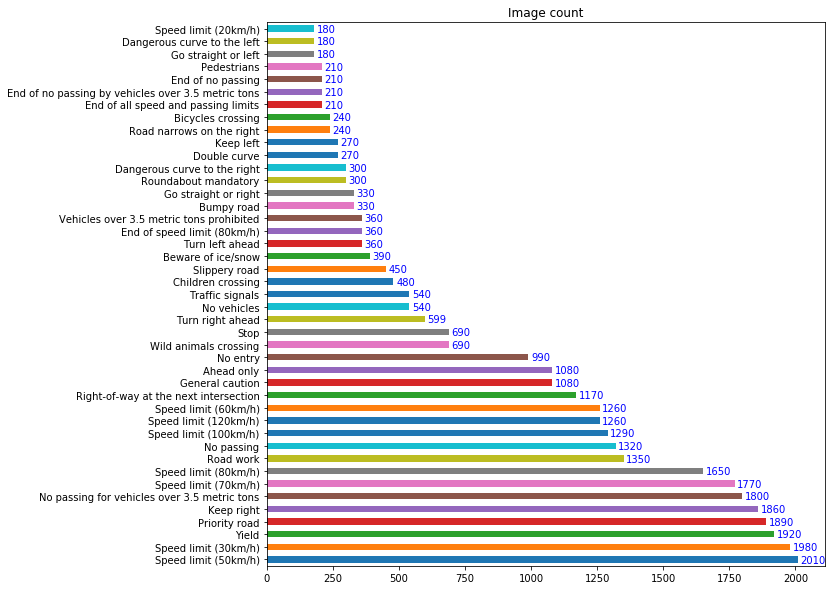

In [11]:
import pandas as pd

def plot_histogram(y_train):
    classes = pd.DataFrame()
    classes['label'] = y_train
    ax = classes['label'].value_counts().plot(kind='barh', figsize = (10,10), title='Image count')
    ax.set_yticklabels(list(map(lambda x: signname[x], classes['label'].value_counts().index.tolist()))) 

    for i, v in enumerate(classes['label'].value_counts()):
        ax.text(v + 10, i - 0.25, str(v), color='b')
plot_histogram(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [12]:
import tensorflow as tf
from spatial_transformer import transformer  # ref:https://github.com/daviddao/spatial-transformer-tensorflow
from tf_utils import weight_variable, bias_variable, dense_to_one_hot
from tensorflow.contrib.layers import flatten


In [13]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
### Shuffling training data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

### Calculate Mean image to be used for normlization of Network input

mean_image = np.mean(X_train,axis=0)

### Model Architecture

# Localization Network
## Create placeholders

__Key idea:__

Placeholders for 32x32 resolution input images.


In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
mean_image_placeholder = tf.placeholder(tf.float32, (32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)
keep_prob_fc = tf.placeholder(tf.float32)
keep_prob_conv = tf.placeholder(tf.float32)

## Setup a two-layer Localization network

__Key idea:__

Setup the two-layer localisation network to figure out the parameters for an affine transformation of the input.  Use identity transformation as starting point.

In [20]:
# Identity transformation
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32')
initial = initial.flatten()

# Create variables for fully connected layer for the localisation network
W_fc_loc1 = weight_variable([600, 100])
b_fc_loc1 = bias_variable([100])

W_fc_loc2 = weight_variable([100, 6])
b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')


## Define a two layer Localization network

__Key idea:__

Use Basic LeNet Arch.and  add regularization technique (dropout) in anticipation for overfitting.

In [21]:
def localization_net(x):
    mu = 0
    sigma = 0.1
    loc_conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    loc_conv1_b = tf.Variable(tf.zeros(6))
    # Layer 1: Convolutional. Output = 28x28x6.
    loc_conv1   = tf.nn.conv2d(x, loc_conv1_W, strides=[1, 1, 1, 1], padding='VALID') + loc_conv1_b

    # layer1: Activation.
    loc_conv1 = tf.nn.relu(loc_conv1)

    # layer1: Pooling. Input = 28x28x6. Output = 14x14x6.
    loc_conv1 = tf.nn.max_pool(loc_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    loc_conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 24), mean = mu, stddev = sigma))
    loc_conv2_b = tf.Variable(tf.zeros(24))
    loc_conv2   = tf.nn.conv2d(loc_conv1, loc_conv2_W, strides=[1, 1, 1, 1], padding='VALID') + loc_conv2_b
    
    # Layer 2: Activation.
    loc_conv2 = tf.nn.relu(loc_conv2)

    # Layer 2: Pooling. Input = 10x10x24. Output = 5x5x24.
    loc_conv2 = tf.nn.max_pool(loc_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Flatten. Input = 5x5x24. Output = 400.
    fc0   = flatten(loc_conv2)
    # Layer 4: Fully connected layers
    h_fc_loc1 = tf.nn.tanh(tf.matmul(fc0, W_fc_loc1) + b_fc_loc1)

    # Layer 5: Dropout for regularization
    h_fc_loc1_drop = tf.nn.dropout(h_fc_loc1, keep_prob)

    # Layer 6: Fully connected layers
    h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1_drop, W_fc_loc2) + b_fc_loc2)
    return h_fc_loc2

In [22]:
def inception_block(input,features_num):
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional 1x1 
    conv1x1_w = tf.Variable(tf.truncated_normal(shape=(1, 1, features_num, 24), mean = mu, stddev = sigma))
    conv1x1_b = tf.Variable(tf.zeros(24))
    conv1x1   = tf.nn.conv2d(input, conv1x1_w, strides=[1, 3, 3, 1], padding='SAME') + conv1x1_b
    conv1x1 = tf.nn.relu(conv1x1)
    
    # Layer 2: Convolutional 3x3 
    conv3x3_w = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 16), mean = mu, stddev = sigma))
    conv3x3_b = tf.Variable(tf.zeros(16))
    conv3x3   = tf.nn.conv2d(conv1x1, conv3x3_w, strides=[1, 1, 1, 1], padding='SAME') + conv3x3_b
    conv3x3 = tf.nn.relu(conv3x3)
    
    # Layer 3: Convolutional 5x5 
    conv5x5_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 8), mean = mu, stddev = sigma))
    conv5x5_b = tf.Variable(tf.zeros(8))
    conv5x5   = tf.nn.conv2d(conv1x1, conv5x5_w, strides=[1, 1, 1, 1], padding='SAME') + conv5x5_b
    conv5x5 = tf.nn.relu(conv5x5)
    
    # Layer 4: max pooling 3x3
    max3x3   = tf.nn.max_pool(conv3x3, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    # Concatenates feature maps
    output = tf.concat([conv1x1, conv3x3,conv5x5,max3x3],3)
    return output 
    
    

In [23]:
def unified_inception_model(x):
    mu = 0
    sigma = 0.1
    
    # normlization layer
    # batch_input = x - mean_image_placeholder
    """
    Input Normalization was tried but tends to give less accuracy than using input data as it
    """
    batch_input = x
    
    ## Create a spatial transformer module
    affain_transformation = localization_net(batch_input)
    x_trans = transformer(batch_input, affain_transformation, (32, 32))
    
    # inception Block #1
    
    inception_1 = inception_block(x_trans,3)
    
    # Dropout layer
    
    inceptoon_dropout = tf.nn.dropout(inception_1, keep_prob_conv)
    
    # inception Block #2
    
    inception_2 = inception_block(inception_1,64)
    
    # Flatten layer
    
    flatten_features   = flatten(inception_2)
    
    # Fully connected layer 1.. Input = 1000. Output = 1000. 
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(flatten_features, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    
    # Fully connected layer 2. Input = 512. Output = 1000.
    
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    
    # Dropout for regularization
    
    fc2_droped = tf.nn.dropout(fc2, keep_prob_fc)
    
    # Fully connected layer3. Input = 100. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2_droped, fc3_W) + fc3_b
    
    return inception_1, inception_2, logits , x_trans

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [27]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 50
BATCH_SIZE = 128
rate = 0.0001

batch_count = int(len(X_train) / BATCH_SIZE)
# Training pipeline 

inception_1, inception_2, logits , x_trans = unified_inception_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
network_output = tf.nn.softmax(logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [25]:
# Validation pipeline
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,mean_image_placeholder:mean_image, keep_prob: 1.0, keep_prob_fc: 1.0, keep_prob_conv: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [28]:
#training phase
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    training_accuracy = []
    validation_accuracy = []
    print("Training...")
    for epoch in range(EPOCHS):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, EPOCHS), unit='batches')
        for offset in batches_pbar:
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, mean_image_placeholder:mean_image, keep_prob: 0.4, keep_prob_fc: 0.5, keep_prob_conv: 0.5})
        
        training_accuracy.append(evaluate(X_train, y_train))
        validation_accuracy.append(evaluate(X_valid, y_valid))
        
        print("EPOCH {} ...".format(epoch+1))
        print("Training Accuracy = {:.5f}".format(training_accuracy[-1]))
        print("Validation Accuracy = {:.5f}".format(validation_accuracy[-1]))
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...



Epoch  1/50: 100%|██████████████████████| 271/271 [01:15<00:00,  3.38batches/s]


EPOCH 1 ...
Training Accuracy = 0.01954
Validation Accuracy = 0.01973


Epoch  2/50: 100%|██████████████████████| 271/271 [01:18<00:00,  3.33batches/s]


EPOCH 2 ...
Training Accuracy = 0.02241
Validation Accuracy = 0.02109


Epoch  3/50: 100%|██████████████████████| 271/271 [01:17<00:00,  3.40batches/s]


EPOCH 3 ...
Training Accuracy = 0.02328
Validation Accuracy = 0.02313


Epoch  4/50: 100%|██████████████████████| 271/271 [01:17<00:00,  3.47batches/s]


EPOCH 4 ...
Training Accuracy = 0.02333
Validation Accuracy = 0.02381


Epoch  5/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.51batches/s]


EPOCH 5 ...
Training Accuracy = 0.02282
Validation Accuracy = 0.02336


Epoch  6/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.47batches/s]


EPOCH 6 ...
Training Accuracy = 0.02287
Validation Accuracy = 0.02200


Epoch  7/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.51batches/s]


EPOCH 7 ...
Training Accuracy = 0.02310
Validation Accuracy = 0.02404


Epoch  8/50: 100%|██████████████████████| 271/271 [01:20<00:00,  3.47batches/s]


EPOCH 8 ...
Training Accuracy = 0.02267
Validation Accuracy = 0.02336


Epoch  9/50: 100%|██████████████████████| 271/271 [01:20<00:00,  3.50batches/s]


EPOCH 9 ...
Training Accuracy = 0.02296
Validation Accuracy = 0.02290


Epoch 10/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.52batches/s]


EPOCH 10 ...
Training Accuracy = 0.02451
Validation Accuracy = 0.02494


Epoch 11/50: 100%|██████████████████████| 271/271 [01:20<00:00,  3.42batches/s]


EPOCH 11 ...
Training Accuracy = 0.02264
Validation Accuracy = 0.02268


Epoch 12/50: 100%|██████████████████████| 271/271 [01:24<00:00,  3.16batches/s]


EPOCH 12 ...
Training Accuracy = 0.02356
Validation Accuracy = 0.02449


Epoch 13/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.45batches/s]


EPOCH 13 ...
Training Accuracy = 0.02253
Validation Accuracy = 0.02313


Epoch 14/50: 100%|██████████████████████| 271/271 [01:28<00:00,  3.39batches/s]


EPOCH 14 ...
Training Accuracy = 0.02348
Validation Accuracy = 0.02404


Epoch 15/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.43batches/s]


EPOCH 15 ...
Training Accuracy = 0.02448
Validation Accuracy = 0.02517


Epoch 16/50: 100%|██████████████████████| 271/271 [01:18<00:00,  3.42batches/s]


EPOCH 16 ...
Training Accuracy = 0.02362
Validation Accuracy = 0.02449


Epoch 17/50: 100%|██████████████████████| 271/271 [01:20<00:00,  3.45batches/s]


EPOCH 17 ...
Training Accuracy = 0.02305
Validation Accuracy = 0.02358


Epoch 18/50: 100%|██████████████████████| 271/271 [01:16<00:00,  3.55batches/s]


EPOCH 18 ...
Training Accuracy = 0.02500
Validation Accuracy = 0.02608


Epoch 19/50: 100%|██████████████████████| 271/271 [01:23<00:00,  3.09batches/s]


EPOCH 19 ...
Training Accuracy = 0.02514
Validation Accuracy = 0.02540


Epoch 20/50: 100%|██████████████████████| 271/271 [01:20<00:00,  3.43batches/s]


EPOCH 20 ...
Training Accuracy = 0.02437
Validation Accuracy = 0.02449


Epoch 21/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.07batches/s]


EPOCH 21 ...
Training Accuracy = 0.02362
Validation Accuracy = 0.02177


Epoch 22/50: 100%|██████████████████████| 271/271 [01:19<00:00,  3.31batches/s]


EPOCH 22 ...
Training Accuracy = 0.02397
Validation Accuracy = 0.02358


Epoch 23/50: 100%|██████████████████████| 271/271 [01:23<00:00,  3.18batches/s]


EPOCH 23 ...
Training Accuracy = 0.02428
Validation Accuracy = 0.02404


Epoch 24/50: 100%|██████████████████████| 271/271 [01:21<00:00,  3.51batches/s]


EPOCH 24 ...
Training Accuracy = 0.02477
Validation Accuracy = 0.02472


Epoch 25/50: 100%|██████████████████████| 271/271 [01:22<00:00,  2.80batches/s]


EPOCH 25 ...
Training Accuracy = 0.02437
Validation Accuracy = 0.02517


Epoch 26/50: 100%|██████████████████████| 271/271 [01:18<00:00,  3.48batches/s]


EPOCH 26 ...
Training Accuracy = 0.02457
Validation Accuracy = 0.02540


Epoch 27/50: 100%|██████████████████████| 271/271 [01:23<00:00,  2.71batches/s]


EPOCH 27 ...
Training Accuracy = 0.02537
Validation Accuracy = 0.02880


Epoch 28/50: 100%|██████████████████████| 271/271 [01:29<00:00,  3.35batches/s]


EPOCH 28 ...
Training Accuracy = 0.02512
Validation Accuracy = 0.02766


Epoch 29/50: 100%|██████████████████████| 271/271 [01:20<00:00,  3.48batches/s]


EPOCH 29 ...
Training Accuracy = 0.02701
Validation Accuracy = 0.03061


Epoch 30/50: 100%|██████████████████████| 271/271 [01:17<00:00,  3.51batches/s]


EPOCH 30 ...
Training Accuracy = 0.02537
Validation Accuracy = 0.02721


Epoch 31/50: 100%|██████████████████████| 271/271 [01:18<00:00,  3.53batches/s]


EPOCH 31 ...
Training Accuracy = 0.02460
Validation Accuracy = 0.02721


Epoch 32/50: 100%|██████████████████████| 271/271 [01:18<00:00,  3.48batches/s]


EPOCH 32 ...
Training Accuracy = 0.02394
Validation Accuracy = 0.02404


Epoch 33/50: 100%|██████████████████████| 271/271 [48:25<00:00, 34.93s/batches]


EPOCH 33 ...
Training Accuracy = 0.02402
Validation Accuracy = 0.02676


Epoch 34/50: 100%|██████████████████████| 271/271 [01:27<00:00,  3.01batches/s]


EPOCH 34 ...
Training Accuracy = 0.02480
Validation Accuracy = 0.02721


Epoch 35/50: 100%|██████████████████████| 271/271 [01:26<00:00,  3.17batches/s]


EPOCH 35 ...
Training Accuracy = 0.02463
Validation Accuracy = 0.02698


Epoch 36/50: 100%|██████████████████████| 271/271 [01:24<00:00,  3.18batches/s]


EPOCH 36 ...
Training Accuracy = 0.02374
Validation Accuracy = 0.02698


Epoch 37/50: 100%|██████████████████████| 271/271 [01:25<00:00,  3.17batches/s]


EPOCH 37 ...
Training Accuracy = 0.02546
Validation Accuracy = 0.02789


Epoch 38/50: 100%|██████████████████████| 271/271 [01:26<00:00,  3.05batches/s]


EPOCH 38 ...
Training Accuracy = 0.02523
Validation Accuracy = 0.02585


Epoch 39/50: 100%|██████████████████████| 271/271 [01:26<00:00,  3.02batches/s]


EPOCH 39 ...
Training Accuracy = 0.02483
Validation Accuracy = 0.02585


Epoch 40/50: 100%|██████████████████████| 271/271 [01:24<00:00,  3.17batches/s]


EPOCH 40 ...
Training Accuracy = 0.02468
Validation Accuracy = 0.02630


Epoch 41/50: 100%|██████████████████████| 271/271 [01:25<00:00,  3.10batches/s]


EPOCH 41 ...
Training Accuracy = 0.02431
Validation Accuracy = 0.02494


Epoch 42/50: 100%|██████████████████████| 271/271 [01:24<00:00,  3.20batches/s]


EPOCH 42 ...
Training Accuracy = 0.02612
Validation Accuracy = 0.03061


Epoch 43/50: 100%|██████████████████████| 271/271 [01:25<00:00,  3.25batches/s]


EPOCH 43 ...
Training Accuracy = 0.02434
Validation Accuracy = 0.02494


Epoch 44/50: 100%|██████████████████████| 271/271 [01:26<00:00,  3.13batches/s]


EPOCH 44 ...
Training Accuracy = 0.02563
Validation Accuracy = 0.02857


Epoch 45/50: 100%|██████████████████████| 271/271 [01:23<00:00,  3.20batches/s]


EPOCH 45 ...
Training Accuracy = 0.02371
Validation Accuracy = 0.02857


Epoch 46/50: 100%|██████████████████████| 271/271 [01:26<00:00,  3.23batches/s]


EPOCH 46 ...
Training Accuracy = 0.02681
Validation Accuracy = 0.02902


Epoch 47/50: 100%|██████████████████████| 271/271 [01:27<00:00,  3.22batches/s]


EPOCH 47 ...
Training Accuracy = 0.02707
Validation Accuracy = 0.02880


Epoch 48/50: 100%|██████████████████████| 271/271 [01:25<00:00,  3.15batches/s]


EPOCH 48 ...
Training Accuracy = 0.02888
Validation Accuracy = 0.03197


Epoch 49/50: 100%|██████████████████████| 271/271 [01:24<00:00,  3.13batches/s]


EPOCH 49 ...
Training Accuracy = 0.02877
Validation Accuracy = 0.03197


Epoch 50/50: 100%|██████████████████████| 271/271 [01:23<00:00,  3.20batches/s]


EPOCH 50 ...
Training Accuracy = 0.02854
Validation Accuracy = 0.03129
Model saved


## Training and Validation Accuracy 

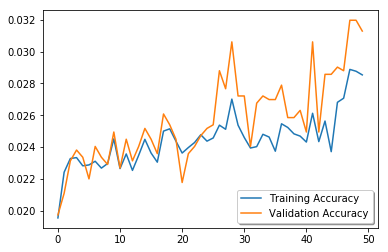

In [29]:
fig, ax = plt.subplots()
ax.plot(training_accuracy, label='Training Accuracy')
ax.plot(validation_accuracy, label='Validation Accuracy')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=True)
plt.show()

## Confusion Matrix for Training Data
Ref : [Confusion Matrix in scikit-learn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

Model restored.
Confusion matrix, without normalization
[[ 28   0   0 ...,   0   0   0]
 [  0 230   4 ...,   0   0   0]
 [  0  10 225 ...,   0   0   0]
 ..., 
 [  0  12   0 ...,  42   0   0]
 [  0   0   0 ...,   0  30   0]
 [  0   0   0 ...,   0   0  30]]


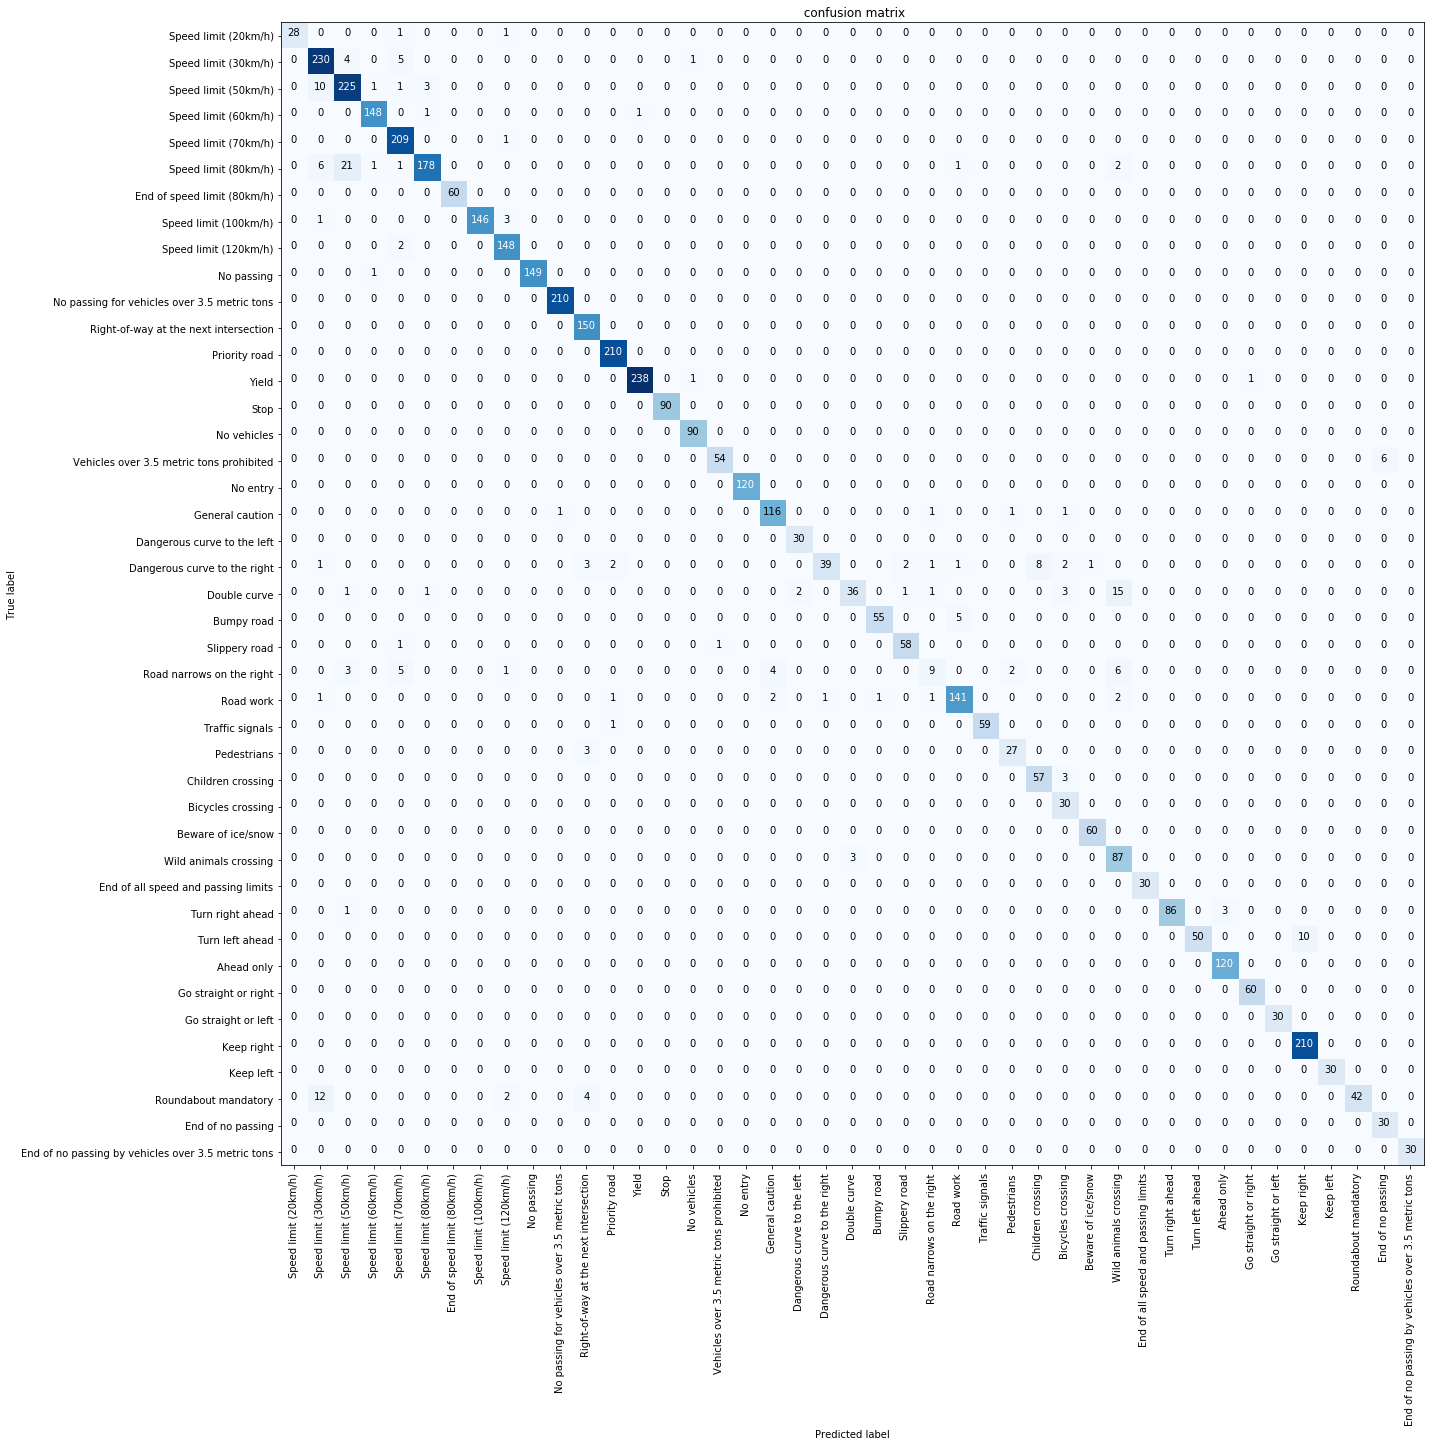

In [35]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    print("Model restored.")
    logits = sess.run(network_output, feed_dict={x: X_valid, y: y_valid, mean_image_placeholder:mean_image, keep_prob: 1.0, keep_prob_fc: 1.0, keep_prob_conv: 1.0})
    y_pred = np.argmax(logits,axis=1)
cnf_matrix = confusion_matrix(y_valid, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=signname, title=' confusion matrix')

---

## Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

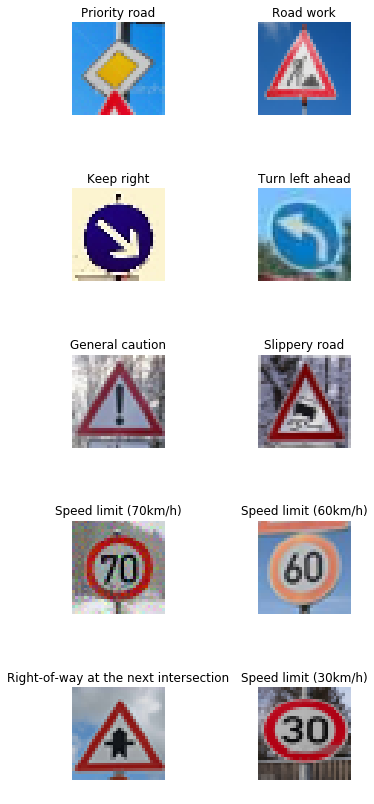

In [36]:
### Load the images and plot them here.
import os
test_images_dir = "test_images/"
test_images=os.listdir(test_images_dir)
images = []
labels = []
f, axarr = plt.subplots(5, 2)
for id,img_name in enumerate(test_images):
    img = cv2.imread(test_images_dir+img_name)
    images.append(img[:,:,::-1])
    labels.append(int(img_name.split('.')[0]))
    axarr[id%5, id // 5].imshow(images[-1])
    axarr[id%5, id // 5].set_title(signname[labels[-1]])
    axarr[id%5, id // 5].set_axis_off()
f.set_size_inches(5,15)
f.subplots_adjust(wspace=1, hspace=0.1)


### Predict the Sign Type for Each Image

In [38]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
def forward_inference(X_data, y_data):
    sess = tf.get_default_session()
    accuracy, transformed_image = sess.run([network_output,x_trans], feed_dict={x: X_data, y: y_data, mean_image_placeholder:mean_image, keep_prob: 1.0, keep_prob_fc: 1.0, keep_prob_conv: 1.0})
    return accuracy, transformed_image


with tf.Session() as sess:
    # Restore variables from disk.
    output_probabilites = []
    transformed_images = []
    predicted_labels = []
    saver.restore(sess, "./lenet")
    print("Model restored.")
    for i in range(len(images)):
        images_TF = tf.expand_dims(images[i], 0)
        img_prob,img_transformed = forward_inference(images_TF.eval(),tf.expand_dims(np.array(labels[i]), 0).eval())
        output_probabilites.append(img_prob)
        transformed_images.append(img_transformed)
        predicted_labels.append((np.argmax(output_probabilites[i][0]),np.max(output_probabilites[i][0])))
        print("model predicted \"{}\" with accuracy {:.5f} but True label is \" {}\" with accuracy {:.5f} ".format(signname[np.argmax(output_probabilites[i][0])],
                                                             np.max(output_probabilites[i][0]),signname[labels[i]],output_probabilites[i][0][labels[i]]))
        
    TopKV5 = sess.run(tf.nn.top_k(tf.constant(np.array(output_probabilites)), k=5))
    print(TopKV5)
    

Model restored.
model predicted "Priority road" with accuracy 1.00000 but True label is " Priority road" with accuracy 1.00000 
model predicted "Keep right" with accuracy 1.00000 but True label is " Keep right" with accuracy 1.00000 
model predicted "General caution" with accuracy 1.00000 but True label is " General caution" with accuracy 1.00000 
model predicted "Speed limit (20km/h)" with accuracy 0.84296 but True label is " Speed limit (70km/h)" with accuracy 0.05448 
model predicted "Right-of-way at the next intersection" with accuracy 1.00000 but True label is " Right-of-way at the next intersection" with accuracy 1.00000 
model predicted "Road work" with accuracy 0.99148 but True label is " Road work" with accuracy 0.99148 
model predicted "Turn left ahead" with accuracy 1.00000 but True label is " Turn left ahead" with accuracy 1.00000 
model predicted "Slippery road" with accuracy 0.99694 but True label is " Slippery road" with accuracy 0.99694 
model predicted "Speed limit (50

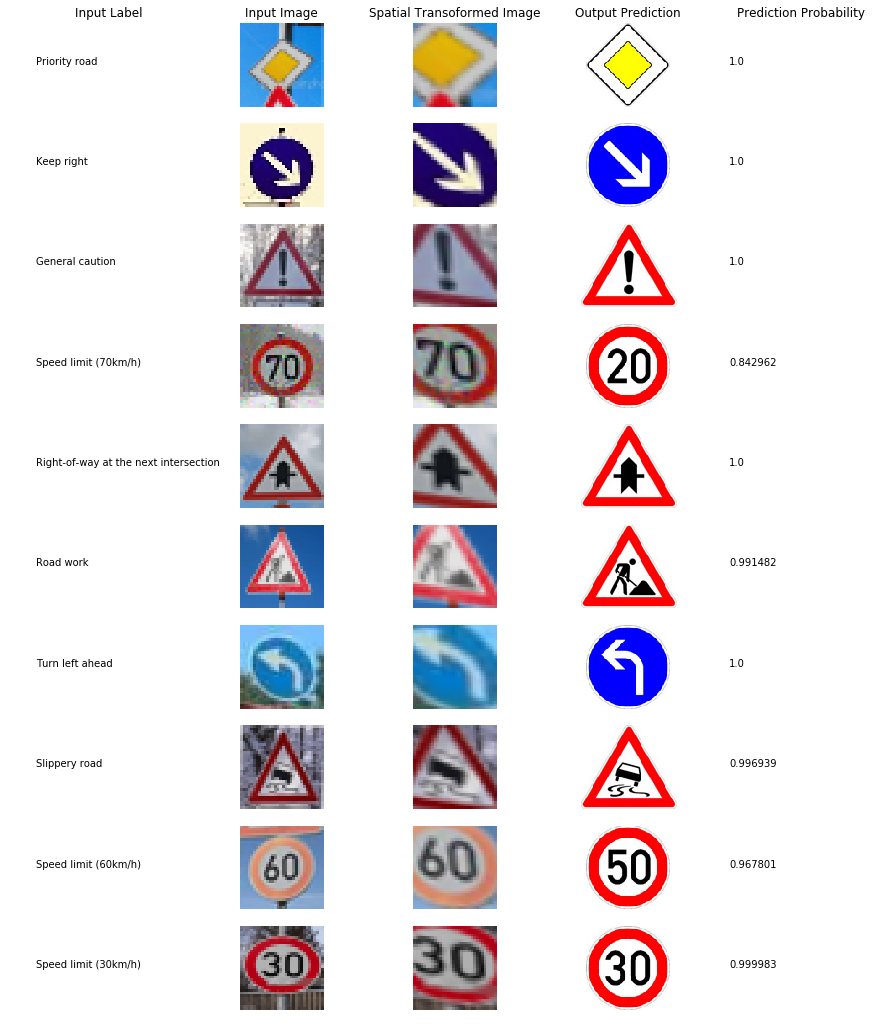

In [73]:
test_gs = gridspec.GridSpec(len(images)+1, 5)

# plot samples for each traffic signs 
data_set_fig = plt.figure(figsize=(15, 20))
# st = data_set_fig.suptitle("Training  DataSet Samples", fontsize="x-large")
ax = []
for img_id in range(len(images)):
    # plot Input Image and label
    ax.append(data_set_fig.add_subplot(test_gs[img_id, 0]))
    ax[-1].text(0, 0.6, signname[labels[img_id]], ha='left', va='top', wrap=True)
    ax[-1].set_axis_off()
    if img_id == 0:
        plt.title('Input Label')
    ax.append(data_set_fig.add_subplot(test_gs[img_id, 1]))
    ax[-1].imshow(images[img_id])
    ax[-1].set_axis_off()
    if img_id == 0:
        plt.title('Input Image')
    # plot Transformation of output
    ax.append(data_set_fig.add_subplot(test_gs[img_id, 2]))
    ax[-1].imshow(np.array(transformed_images[img_id][0],dtype=np.uint8))
    ax[-1].set_axis_off()
    if img_id == 0:
        plt.title('Spatial Transoformed Image')
    #plot predected sign image and accuarcy 
    ax.append(data_set_fig.add_subplot(test_gs[img_id, 3]))
    gt_image_id = np.where(np.array(ground_truth_labels)==predicted_labels[img_id][0])[0][0]
    ax[-1].imshow(ground_truth_signs[gt_image_id])
    ax[-1].set_axis_off()
    if img_id == 0:
        plt.title('Output Prediction')
    ax.append(data_set_fig.add_subplot(test_gs[img_id, 4]))
    ax[-1].text(0, 0.6, str(predicted_labels[img_id][1]), ha='left', va='top', wrap=True)
    ax[-1].set_axis_off()
    if img_id == 0:
        plt.title('Prediction Probability')
    

### Analyze Performance

In [69]:
### Given new small test dataset, Model Accuracy is calculated below
overall_accuracy = 0
for sample_id, sample_result in enumerate(output_probabilites):   
    if np.argmax(sample_result[0]) == labels[sample_id]:
        overall_accuracy += 1
overall_accuracy = overall_accuracy / float(len(output_probabilites))
print("Model Accuracy over small test set = {:.2f} %".format(overall_accuracy*100))

Model Accuracy over small test set = 80.00 %


# Test Dataset Accuracy

In [30]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./lenet")
    print(evaluate(X_test,y_test))

INFO:tensorflow:Restoring parameters from ./lenet


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [1,1,3,24] rhs shape= [16]
	 [[Node: save/Assign_2 = Assign[T=DT_FLOAT, _class=["loc:@Variable_10"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_10, save/RestoreV2_2)]]

Caused by op 'save/Assign_2', defined at:
  File "D:\Anaconda_36\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda_36\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-68d3944b4860>", line 4, in <module>
    saver = tf.train.Saver()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1218, in __init__
    self.build()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 439, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 160, in restore
    self.op.get_shape().is_fully_defined())
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\ops\state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 56, in assign
    use_locking=use_locking, name=name)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [1,1,3,24] rhs shape= [16]
	 [[Node: save/Assign_2 = Assign[T=DT_FLOAT, _class=["loc:@Variable_10"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_10, save/RestoreV2_2)]]


---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [54]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation,figure_title="Layer_Visualization", activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input,keep_prob:1})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(20,20))
    plt.suptitle(figure_title, fontsize=18)
    for featuremap in range(featuremaps):
        plt.subplot(10,10, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Model restored.


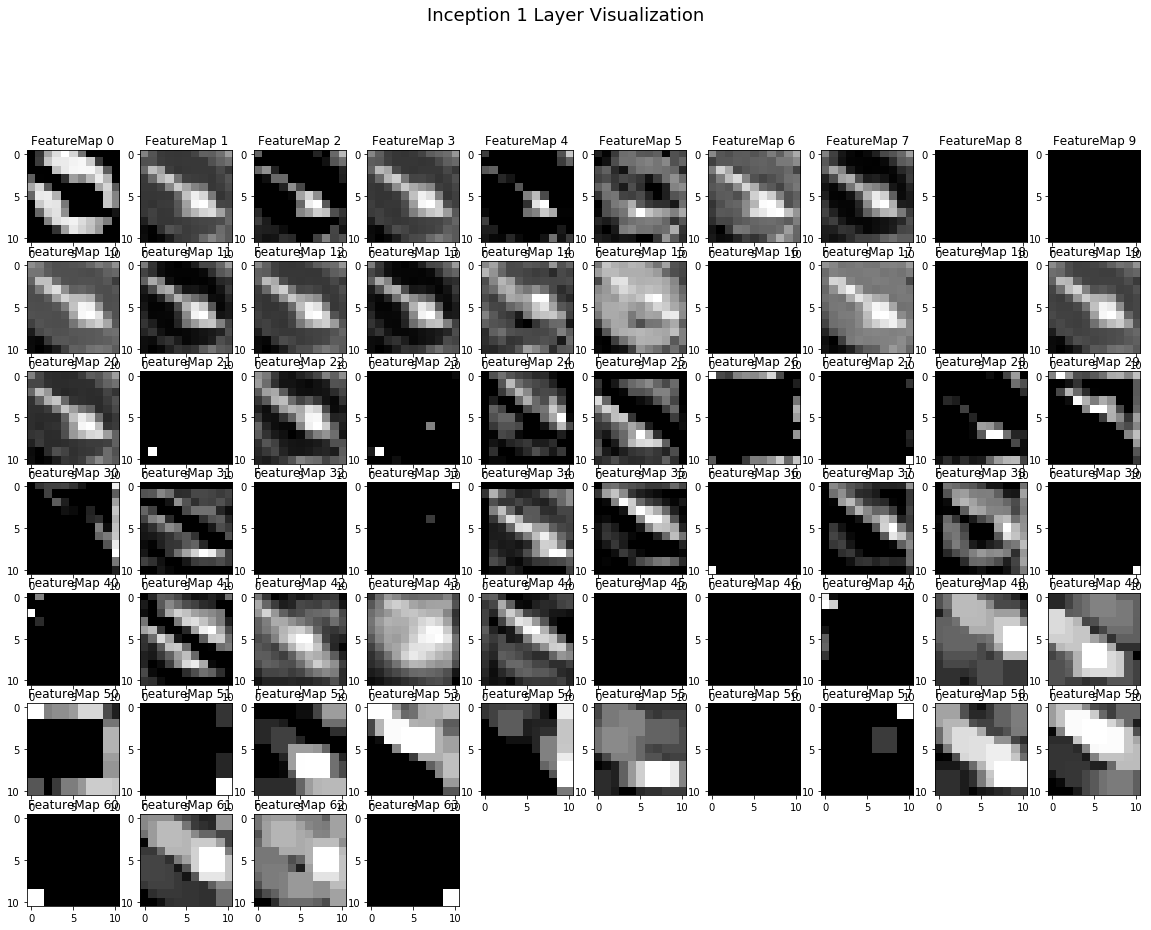

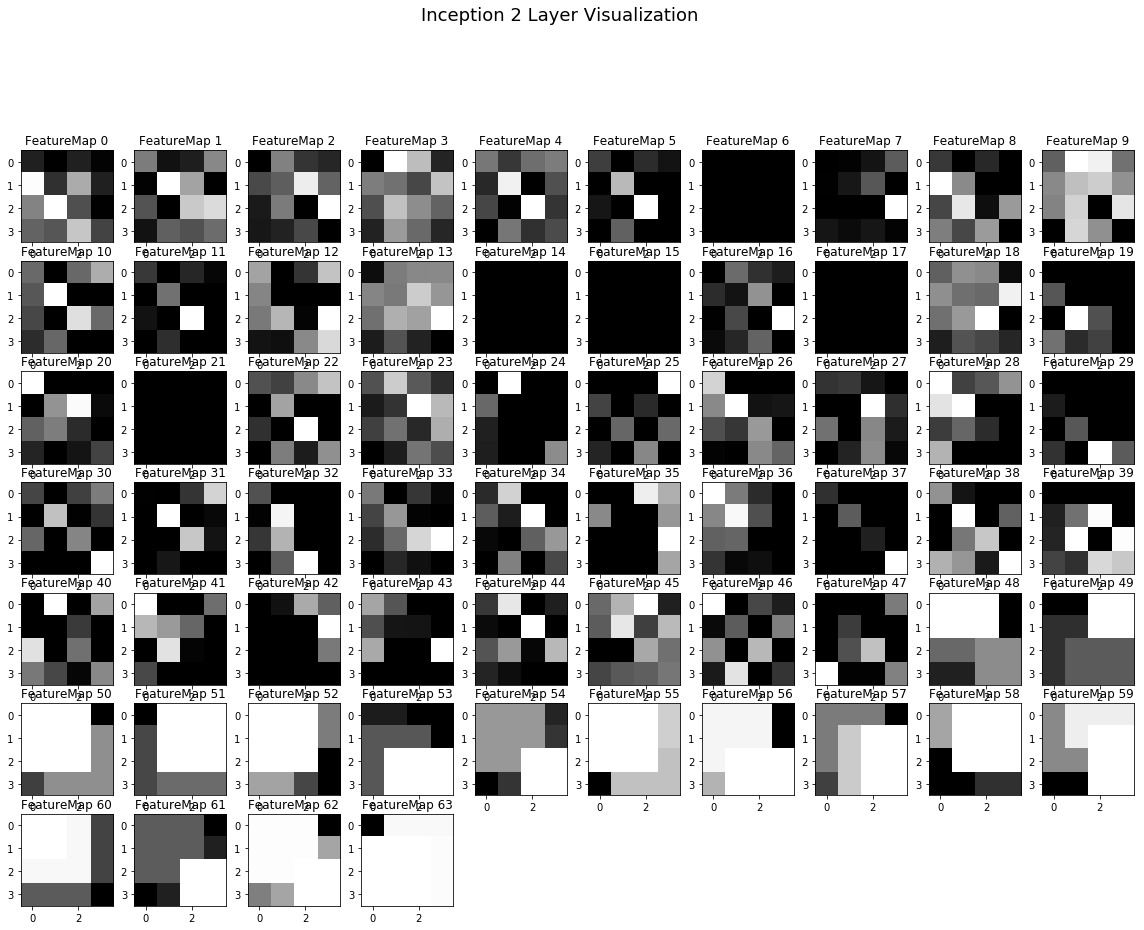

In [76]:
import random

with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    print("Model restored.")
    index = random.randint(0, len(X_test))
    image = X_test[index].squeeze()
    images_TF = tf.expand_dims(np.array(image), 0)
    outputFeatureMap(images_TF.eval(), inception_1,figure_title="Inception 1 Layer Visualization", plt_num=1)
    outputFeatureMap(images_TF.eval(), inception_2,figure_title="Inception 2 Layer Visualization", plt_num=2)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:** Visualization of Inner layers outputs helps detection of overfitting and analysis of learned features in every layer